In [1]:
import torch
from torch.utils.data import DataLoader
import PIL
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.autonotebook import tqdm
from unet import UNet
import os
import albumentations as albu
import torchvision


/var/folders/6z/5dym1p0s1d78371rnh80qlrh0000gn/T/ipykernel_62394/4067242671.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
n_classes= 2    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 4       #depth of the network 
wf= 5           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upconv' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size=3
patch_size=512
num_epochs = 500
edge_weight = 1.1 #edges tend to be the most poorly segmented given how little area they occupy in the training set, this paramter boosts their values along the lines of the original UNET paper
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"]

In [3]:
model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	1928450


In [5]:
checkpoint = torch.load(f"/Users/srmedinac/Documents/BMEPhD/utils/Prostate info/patrick_data_scripts/models/lumen10x_41_1000.pth", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_dict"])

<All keys matched successfully>

In [70]:
class PatchesInference(torch.utils.data.Dataset):
    def __init__(self, patch_folder):
        self.patch_folder = patch_folder
        self.patch_list = [file for file in os.listdir(self.patch_folder) if not file.startswith('.DS_Store')]
        
    
    def __len__(self):
        return len(self.patch_list)
    
    def __getitem__(self, idx):
        patch = PIL.Image.open(os.path.join(self.patch_folder, self.patch_list[idx]))
        patch = torchvision.transforms.PILToTensor()(patch)
        patch = patch / 255.0
        return patch, self.patch_list[idx]


In [73]:
test_loader = DataLoader(PatchesInference("/Users/srmedinac/Documents/BMEPhD/data/upenn_decipher_patches/13-4172 3U/tiles"), batch_size=1, shuffle=False, num_workers=0)

In [74]:
model = model.eval()
model.to(torch.device('mps'))
for inputs, filenames in tqdm(test_loader): #tqdm not working properly in notebook
    # Move tensors to the device for computation
    inputs = inputs.to(torch.device('mps'))
    # Forward pass through the model
    outputs = model(inputs)
    
    # For each image in the batch
    for idx, output in enumerate(outputs):
        # Use argmax to create the segmentation mask
        segmentation_mask = torch.argmax(output, dim=0)
        
        # Convert tensor to numpy array
        segmentation_mask_np = segmentation_mask.detach().cpu().numpy()
        
        # Save the mask
        filename = os.path.splitext(filenames[idx])[0]  # Remove the extension
        output_filename = f"{filename}_mask.png"  # Append '_mask' before the extension
        output_filepath = os.path.join('/Users/srmedinac/Documents/BMEPhD/data/upenn_decipher_patches/13-4172 3U/predicted_masks/', output_filename)  # Substitute '<specified_folder>' with your desired folder path
        # Save the mask using PIL
        segmentation_mask_np = (segmentation_mask_np * 255).astype(np.uint8)
        PIL.Image.fromarray(segmentation_mask_np).save(output_filepath)

  0%|          | 0/896 [00:00<?, ?it/s]

In [41]:
sample_img = torch.tensor(np.array(PIL.Image.open('/Users/srmedinac/Documents/BMEPhD/data/SHIH_patches/38532/tiles/x32000_y28000_w2000_h2000.jpeg')))
sample_img_for_viz = sample_img
sample_img = sample_img / 255.0
sample_img = sample_img.permute(2, 0, 1)
sample_img = torch.unsqueeze(sample_img, 0)
output=model(sample_img)
output=output.detach().squeeze().numpy()
segmentation_mask = np.argmax(output, axis=0)

In [22]:
segmentation_mask.shape

(2000, 2000)

In [42]:
mask = mask.squeeze().transpose(1, 2, 0)
sample_img = sample_img.squeeze().permute(1, 2, 0)
image_overlay = np.array(sample_img).copy()
print(image_overlay.shape, segmentation_mask.shape)
image_overlay[segmentation_mask == 1] = [0, 255, 0]  # RGB for green color

(2000, 2000, 3) (2000, 2000)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


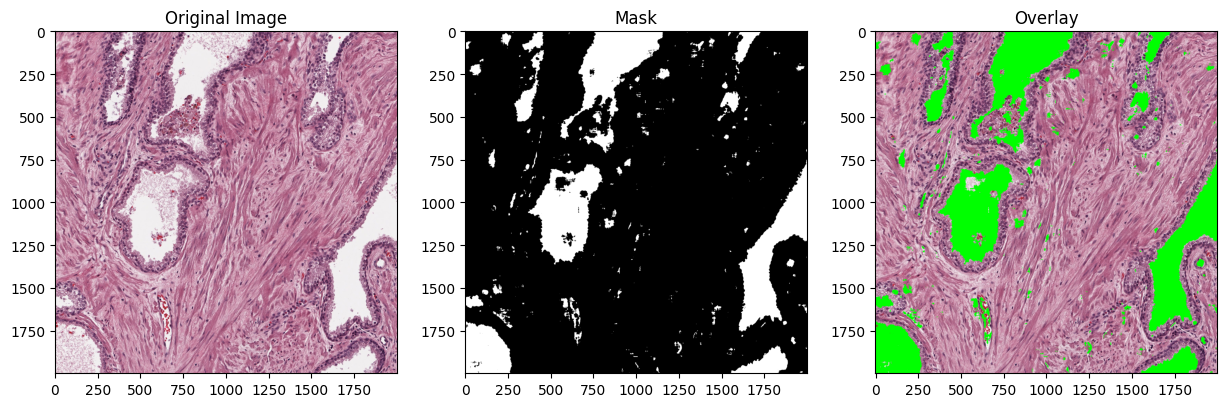

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(sample_img)
ax[0].set_title("Original Image")
ax[1].imshow(segmentation_mask, cmap='gray')
ax[1].set_title("Mask")
ax[2].imshow(image_overlay)
ax[2].set_title("Overlay")
plt.show()

torch.Size([2000, 2000, 3])
(2000, 2000, 3)


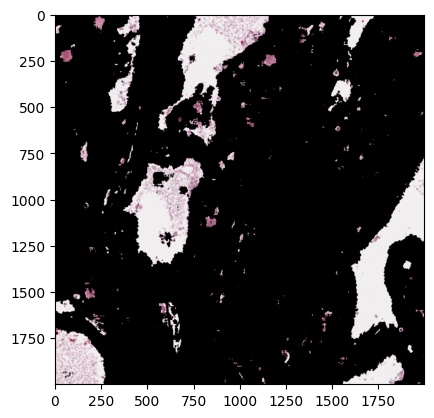

In [52]:
# keep only the masked tissue regions
print(sample_img.shape)
image_masked = np.zeros_like(sample_img)
print(image_masked.shape)
# Copy the pixels from the original image where the mask equals 1
image_masked[segmentation_mask == 1] = sample_img[segmentation_mask == 1]

# Save the new image
#plt.imsave('masked_image.png', image_masked)
plt.imshow(image_masked)
